In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import h5py
import glob
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, DepthwiseConv2D, Activation,
    AveragePooling2D, SeparableConv2D, Flatten, Dense, Dropout,
    GlobalAveragePooling2D, Reshape, Multiply
)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. SETUP PATHS AND CONSTANTS ---
BASE_PATH_CROSS = '/content/drive/MyDrive/Final Project data/Cross'
BASE_PATH_INTRA = '/content/drive/MyDrive/Final Project data/Intra'

CROSS_TRAIN_DIR = os.path.join(BASE_PATH_CROSS, 'train/')
TEST1_DIR = os.path.join(BASE_PATH_CROSS, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH_CROSS, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH_CROSS, 'test3/')
INTRA_TRAIN_DIR = os.path.join(BASE_PATH_INTRA, 'train/')
INTRA_TEST_DIR = os.path.join(BASE_PATH_INTRA, 'test/')

N_CHANNELS = 248
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
task_to_label = {task: i for i, task in enumerate(TASKS)}
DOWNSAMPLE_FACTOR = 10
STEP = 50

# --- 2. HELPER FUNCTIONS ---
def get_file_paths(directory):
    files = glob.glob(f"{directory}/*.h5")
    if not files: raise FileNotFoundError(f"No files found in {directory}")
    return files

def load_data(file_paths):
    data, labels = [], []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        task = None
        if 'rest' in filename: task = 'rest'
        elif 'motor' in filename: task = 'task_motor'
        elif 'story' in filename or 'math' in filename: task = 'task_story_math'
        elif 'working' in filename or 'memory' in filename: task = 'task_working_memory'
        if task:
            labels.append(task_to_label[task])
            with h5py.File(file_path, 'r') as f: data.append(f[list(f.keys())[0]][()])
    return np.array(data), np.array(labels)

def windowing(data, labels, window_size, step):
    X_win, y_win = [], []
    for i in range(data.shape[0]):
        n_windows = (data.shape[2] - window_size) // step + 1
        for j in range(n_windows):
            X_win.append(data[i, :, j * step:j * step + window_size])
            y_win.append(labels[i])
    return np.array(X_win), np.array(y_win)

def normalize_data(data):
    n_samples, n_channels, n_timesteps = data.shape
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)
    return StandardScaler().fit_transform(reshaped_data).reshape(n_samples, n_channels, n_timesteps)

def augment_data(data, labels):
    aug_data, aug_labels = list(data), list(labels)
    for i in range(len(data)):
        noise = np.random.normal(loc=0.0, scale=0.05, size=data[i].shape)
        scaler = np.random.uniform(low=0.9, high=1.1)
        aug_data.append((data[i] + noise) * scaler)
        aug_labels.append(labels[i])
    return np.array(aug_data), np.array(aug_labels)

def preprocess_pipeline(base_dir, window_size, step_size, is_training=True, output_format='2d'):
    files = get_file_paths(base_dir)
    X, y = load_data(files)
    X_ds = X[:, :, ::DOWNSAMPLE_FACTOR]
    X_win, y_win = windowing(X_ds, y, window_size, step_size)
    X_norm = normalize_data(X_win)
    if is_training: final_X, final_y = augment_data(X_norm, y_win)
    else: final_X, final_y = X_norm, y_win
    if output_format == '2d': final_X = final_X[..., np.newaxis]
    elif output_format == '1d': final_X = np.transpose(final_X, (0, 2, 1))
    else: raise ValueError("Invalid output_format")
    return final_X, final_y

def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    filters = init.shape[-1]
    se = GlobalAveragePooling2D()(init)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([init, se])

preprocessing test data for window size: 100
preprocessing test data for window size: 150
preprocessing test data for window size: 200
training and evaluating for window size: 100
training model for window size 100


Evaluating model for window size 100 on test sets...
average cross accuracy for window size 100: 0.7417
training and evaluating for window size: 150
training model for window size 150


Evaluating model for window size 150 on test sets...
average cross accuracy for window size 150: 0.7032
training and evaluating for window size: 200
training model for window size 200


Evaluating model for window size 200 on test sets...
average cross accuracy for window size 200: 0.7086
Best performing window size: 100


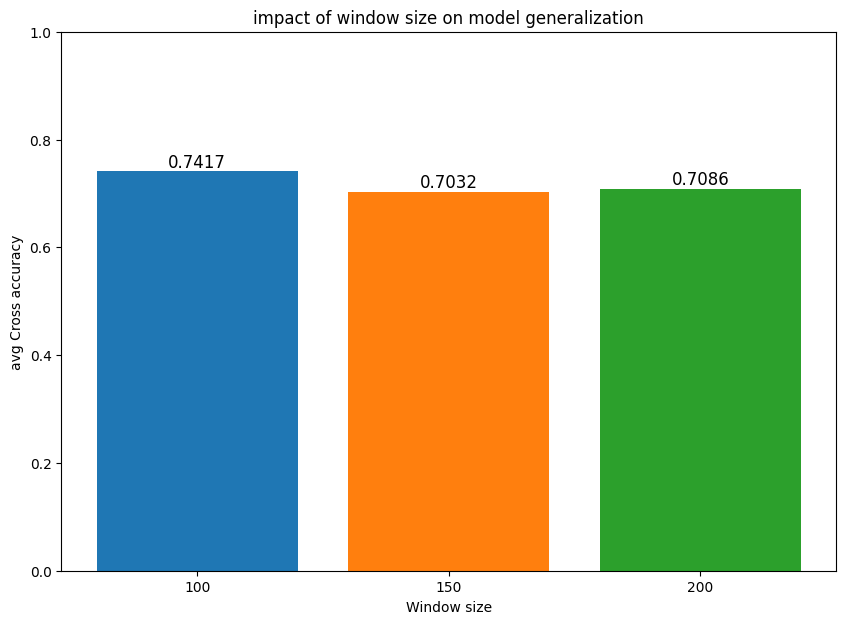

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, AveragePooling2D, DepthwiseConv2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_base_eegnet(nb_classes, Chans, Samples):
    input1 = Input(shape=(Chans, Samples, 1))
    block1 = Conv2D(8, (1, 64), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(0.5)(block1)
    block2 = SeparableConv2D(16, (1, 16), use_bias=False, padding='valid')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(0.5)(block2)
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.25))(flatten)
    softmax = Activation('softmax')(dense)
    return Model(inputs=input1, outputs=softmax)

window_sizes_to_test = [100, 150, 200]
step_size = 50
results = {}


test_data_cache = {}
for size in window_sizes_to_test:
    print(f"preprocessing test data for window size: {size}")
    X_test1, y_test1 = preprocess_pipeline(TEST1_DIR, window_size=size, step_size=step_size, is_training=False, output_format='2d')
    X_test2, y_test2 = preprocess_pipeline(TEST2_DIR, window_size=size, step_size=step_size, is_training=False, output_format='2d')
    X_test3, y_test3 = preprocess_pipeline(TEST3_DIR, window_size=size, step_size=step_size, is_training=False, output_format='2d')
    test_data_cache[size] = [(X_test1, y_test1), (X_test2, y_test2), (X_test3, y_test3)]


for size in window_sizes_to_test:
    print(f"training and evaluating for window size: {size}")

    X_train_exp, y_train_exp = preprocess_pipeline(
        CROSS_TRAIN_DIR,
        window_size=size,
        step_size=step_size,
        is_training=True,
        output_format='2d'
    )

    model_exp = build_base_eegnet(nb_classes=len(TASKS), Chans=N_CHANNELS, Samples=size)
    model_exp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_cb = ModelCheckpoint(f'model_ws_{size}.h5', monitor='val_loss', save_best_only=True, verbose=0)
    early_stop_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

    print(f"training model for window size {size}")
    model_exp.fit(
        X_train_exp, y_train_exp,
        batch_size=32,
        epochs=20,
        validation_split=0.2,
        callbacks=[checkpoint_cb, early_stop_cb],
        verbose=0
    )
    print(f"Evaluating model for window size {size} on test sets...")
    model_exp.load_weights(f'model_ws_{size}.h5')
    (X_test1_final, y_test1_final), (X_test2_final, y_test2_final), (X_test3_final, y_test3_final) = test_data_cache[size]

    acc1 = model_exp.evaluate(X_test1_final, y_test1_final, verbose=0)[1]
    acc2 = model_exp.evaluate(X_test2_final, y_test2_final, verbose=0)[1]
    acc3 = model_exp.evaluate(X_test3_final, y_test3_final, verbose=0)[1]

    avg_acc = np.mean([acc1, acc2, acc3])
    results[size] = avg_acc
    print(f"average cross accuracy for window size {size}: {avg_acc:.4f}")

best_window_size = max(results, key=results.get)
print(f"Best performing window size: {best_window_size}")

window_labels = [str(size) for size in results.keys()]
avg_accuracies = list(results.values())

plt.figure(figsize=(10, 7))
bars = plt.bar(window_labels, avg_accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('Window size')
plt.ylabel('avg Cross accuracy')
plt.title('impact of window size on model generalization')
plt.ylim(0, 1.0)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)
plt.show()

--- Preprocessing test data for window size: 100 ---
--- Preprocessing test data for window size: 150 ---
--- Preprocessing test data for window size: 200 ---

--- Training and Evaluating for Window Size: 100 ---
training model for window size 100


evaluating model for window size 100 on test sets
--> Average Cross-Subject Accuracy for window size 100: 0.7432

--- Training and Evaluating for Window Size: 150 ---
training model for window size 150


evaluating model for window size 150 on test sets
--> Average Cross-Subject Accuracy for window size 150: 0.7663

--- Training and Evaluating for Window Size: 200 ---
training model for window size 200


evaluating model for window size 200 on test sets
--> Average Cross-Subject Accuracy for window size 200: 0.7794




best window size: 200


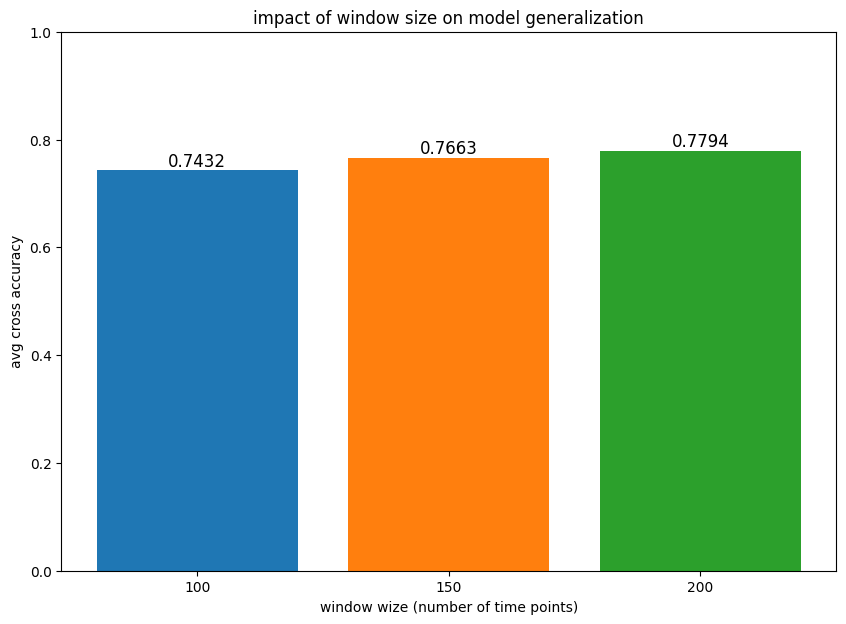

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, AveragePooling2D, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    filters = init.shape[-1]
    se = GlobalAveragePooling2D()(init)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([init, se])

def EEGNet_with_Attention_Regularized(
    nb_classes, Chans, Samples, dropoutRate=0.5, kernLength=64,
    F1=8, D=2, F2=16, l2_lambda=0.001
):
    input1 = Input(shape=(Chans, Samples, 1))
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)
    block1_attention = squeeze_excite_block(block1)
    block2 = SeparableConv2D(
        F2, (1, 16), use_bias=False, padding='valid',
        depthwise_regularizer=l2(l2_lambda), pointwise_regularizer=l2(l2_lambda)
    )(block1_attention)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.25), kernel_regularizer=l2(l2_lambda))(flatten)
    softmax = Activation('softmax')(dense)
    return Model(inputs=input1, outputs=softmax)

window_sizes_to_test = [100, 150, 200]
step_size = 50
results = {}

test_data_cache = {}
for size in window_sizes_to_test:
    print(f"--- Preprocessing test data for window size: {size} ---")
    X_test1, y_test1 = preprocess_pipeline(TEST1_DIR, window_size=size, step_size=step_size, is_training=False, output_format='2d')
    X_test2, y_test2 = preprocess_pipeline(TEST2_DIR, window_size=size, step_size=step_size, is_training=False, output_format='2d')
    X_test3, y_test3 = preprocess_pipeline(TEST3_DIR, window_size=size, step_size=step_size, is_training=False, output_format='2d')
    test_data_cache[size] = [(X_test1, y_test1), (X_test2, y_test2), (X_test3, y_test3)]

for size in window_sizes_to_test:
    print(f"\n--- Training and Evaluating for Window Size: {size} ---")

    X_train_exp, y_train_exp = preprocess_pipeline(CROSS_TRAIN_DIR, window_size=size, step_size=step_size, is_training=True, output_format='2d')

    model_exp = EEGNet_with_Attention_Regularized(
        nb_classes=len(TASKS),
        Chans=N_CHANNELS,
        Samples=size,
        dropoutRate=0.5,
        l2_lambda=0.001,
        F1=8,
        F2=16
    )
    model_exp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_cb = ModelCheckpoint(f'model_ws_{size}.h5', monitor='val_loss', save_best_only=True, verbose=0)
    early_stop_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    print(f"training model for window size {size}")
    model_exp.fit(
        X_train_exp, y_train_exp,
        batch_size=32,
        epochs=20,
        validation_split=0.2,
        callbacks=[checkpoint_cb, early_stop_cb],
        verbose=0
    )

    print(f"evaluating model for window size {size} on test sets")
    model_exp.load_weights(f'model_ws_{size}.h5')
    (X_test1_final, y_test1_final), (X_test2_final, y_test2_final), (X_test3_final, y_test3_final) = test_data_cache[size]
    acc1 = model_exp.evaluate(X_test1_final, y_test1_final, verbose=0)[1]
    acc2 = model_exp.evaluate(X_test2_final, y_test2_final, verbose=0)[1]
    acc3 = model_exp.evaluate(X_test3_final, y_test3_final, verbose=0)[1]

    avg_acc = np.mean([acc1, acc2, acc3])
    results[size] = avg_acc
    print(f"--> Average Cross-Subject Accuracy for window size {size}: {avg_acc:.4f}")

best_window_size = max(results, key=results.get)
print("\n\n\n")
print(f"best window size: {best_window_size}")


window_labels = [str(size) for size in results.keys()]
avg_accuracies = list(results.values())
plt.figure(figsize=(10, 7))
bars = plt.bar(window_labels, avg_accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('window wize ')
plt.ylabel('avg cross accuracy')
plt.title('impact of window size on model generalization')
plt.ylim(0, 1.0)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)
plt.show()

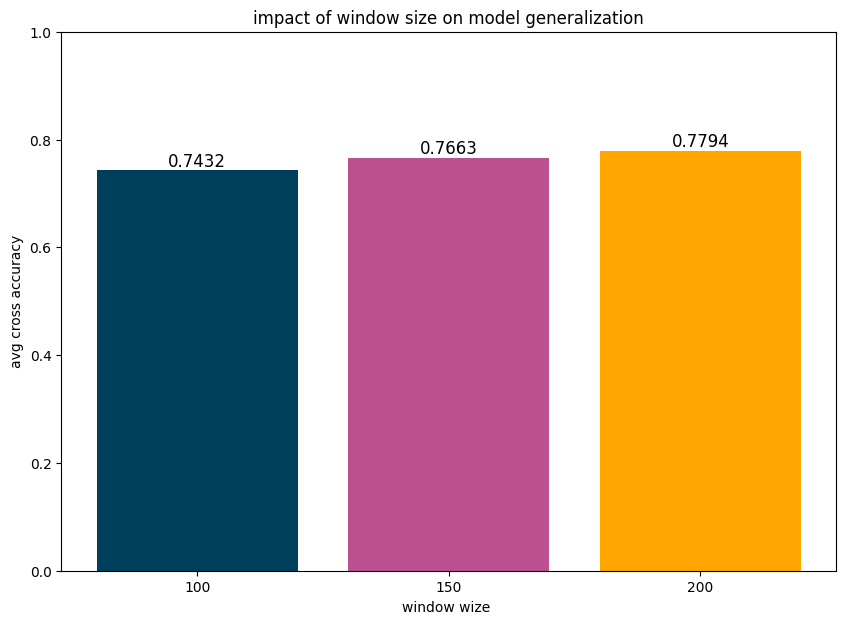

In [10]:
window_labels = [str(size) for size in results.keys()]
avg_accuracies = list(results.values())
plt.figure(figsize=(10, 7))
bars = plt.bar(window_labels, avg_accuracies, color=['#003f5c', '#bc5090', '#ffa600'])
plt.xlabel('window wize ')
plt.ylabel('avg cross accuracy')
plt.title('impact of window size on model generalization')
plt.ylim(0, 1.0)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)
plt.show()

In [11]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [13]:
import keras_tuner as kt
import tensorflow as tf
import pandas as pd
import numpy as np
BEST_WINDOW_SIZE = 200

def build_tunable_eegnet(hp):
    hp_dropout = hp.Choice('dropout_rate', values=[0.25, 0.5, 0.6])
    hp_l2 = hp.Choice('l2_lambda', values=[0.01, 0.001, 0.0001])
    hp_f1_filters = hp.Choice('f1_filters', values=[8, 16, 24])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    input1 = Input(shape=(N_CHANNELS, BEST_WINDOW_SIZE, 1))
    block1 = Conv2D(hp_f1_filters, (1, 64), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((N_CHANNELS, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(hp_dropout)(block1)
    block1_attention = squeeze_excite_block(block1)
    block2 = SeparableConv2D(
        hp_f1_filters * 2, (1, 16), use_bias=False, padding='valid',
        depthwise_regularizer=l2(hp_l2), pointwise_regularizer=l2(hp_l2)
    )(block1_attention)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(hp_dropout)(block2)
    flatten = Flatten()(block2)
    dense = Dense(len(TASKS), kernel_constraint=max_norm(0.25), kernel_regularizer=l2(hp_l2))(flatten)
    softmax = Activation('softmax')(dense)
    model = Model(inputs=input1, outputs=softmax)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print(f"preparing data with window size ({BEST_WINDOW_SIZE})")
X_train_cross, y_train_cross = preprocess_pipeline(CROSS_TRAIN_DIR, window_size=BEST_WINDOW_SIZE, step_size=STEP, is_training=True)
X_train_intra, y_train_intra = preprocess_pipeline(INTRA_TRAIN_DIR, window_size=BEST_WINDOW_SIZE, step_size=STEP, is_training=True)
X_train_tune = np.concatenate((X_train_cross, X_train_intra), axis=0)
y_train_tune = np.concatenate((y_train_cross, y_train_intra), axis=0)

tuner = kt.Hyperband(
    build_tunable_eegnet,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='eegnet_meg_prediction'
)

print("\n--- Starting Initial Hyperparameter Search ---")
tuner.search(
    X_train_tune, y_train_tune,
    epochs=30,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

print("Initial search complete. Now starting evaluation of top trials")
print(f"\n--- Preparing test sets with window size: {BEST_WINDOW_SIZE} ---")
X_test1_final, y_test1_final = preprocess_pipeline(TEST1_DIR, window_size=BEST_WINDOW_SIZE, step_size=STEP, is_training=False)
X_test2_final, y_test2_final = preprocess_pipeline(TEST2_DIR, window_size=BEST_WINDOW_SIZE, step_size=STEP, is_training=False)
X_test3_final, y_test3_final = preprocess_pipeline(TEST3_DIR, window_size=BEST_WINDOW_SIZE, step_size=STEP, is_training=False)

# b. Get the top 5 candidate trials
top_trials = tuner.oracle.get_best_trials(num_trials=5)
evaluation_results = []

for i, trial in enumerate(top_trials):
    print(f"\n evaluating trial {i+1}/{len(top_trials)} ---")
    hps = trial.hyperparameters
    print(f"hyperparameters: {hps.values}")

    model = tuner.hypermodel.build(hps)
    model.fit(X_train_tune, y_train_tune, epochs=40, batch_size=32, verbose=0)

    print("evaluating on test sets")
    acc1 = model.evaluate(X_test1_final, y_test1_final, verbose=0)[1]
    acc2 = model.evaluate(X_test2_final, y_test2_final, verbose=0)[1]
    acc3 = model.evaluate(X_test3_final, y_test3_final, verbose=0)[1]
    avg_acc = np.mean([acc1, acc2, acc3])
    print(f"avg cross accuracy: {avg_acc:.4f}")

    result_entry = hps.values
    result_entry['avg_cross_subject_accuracy'] = avg_acc
    evaluation_results.append(result_entry)


print("$$$$ final results $$$$")


results_df = pd.DataFrame(evaluation_results)
results_df = results_df.sort_values(by='avg_cross_subject_accuracy', ascending=False)

print("top trials evaluated by Average Cross accuracy:")
print(results_df.to_string())

print("\nalso the best set of hyperparameters for generalization is:")
best_hyperparameters_final = results_df.iloc[0].to_dict()
print(best_hyperparameters_final)

Trial 30 Complete [00h 03m 21s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 34m 05s
Initial search complete. Now starting evaluation of top trials

--- Preparing test sets with window size: 200 ---

 evaluating trial 1/5 ---
hyperparameters: {'dropout_rate': 0.5, 'l2_lambda': 0.01, 'f1_filters': 24, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
evaluating on test sets
avg cross accuracy: 0.6651

 evaluating trial 2/5 ---
hyperparameters: {'dropout_rate': 0.6, 'l2_lambda': 0.0001, 'f1_filters': 8, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
evaluating on test sets
avg cross accuracy: 0.6731

 evaluating trial 3/5 ---
hyperparameters: {'dropout_rate': 0.5, 'l2_lambda': 0.001, 'f1_filters': 24, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
evaluating on test sets
avg cross accur

<ipython-input-15-1736964258>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


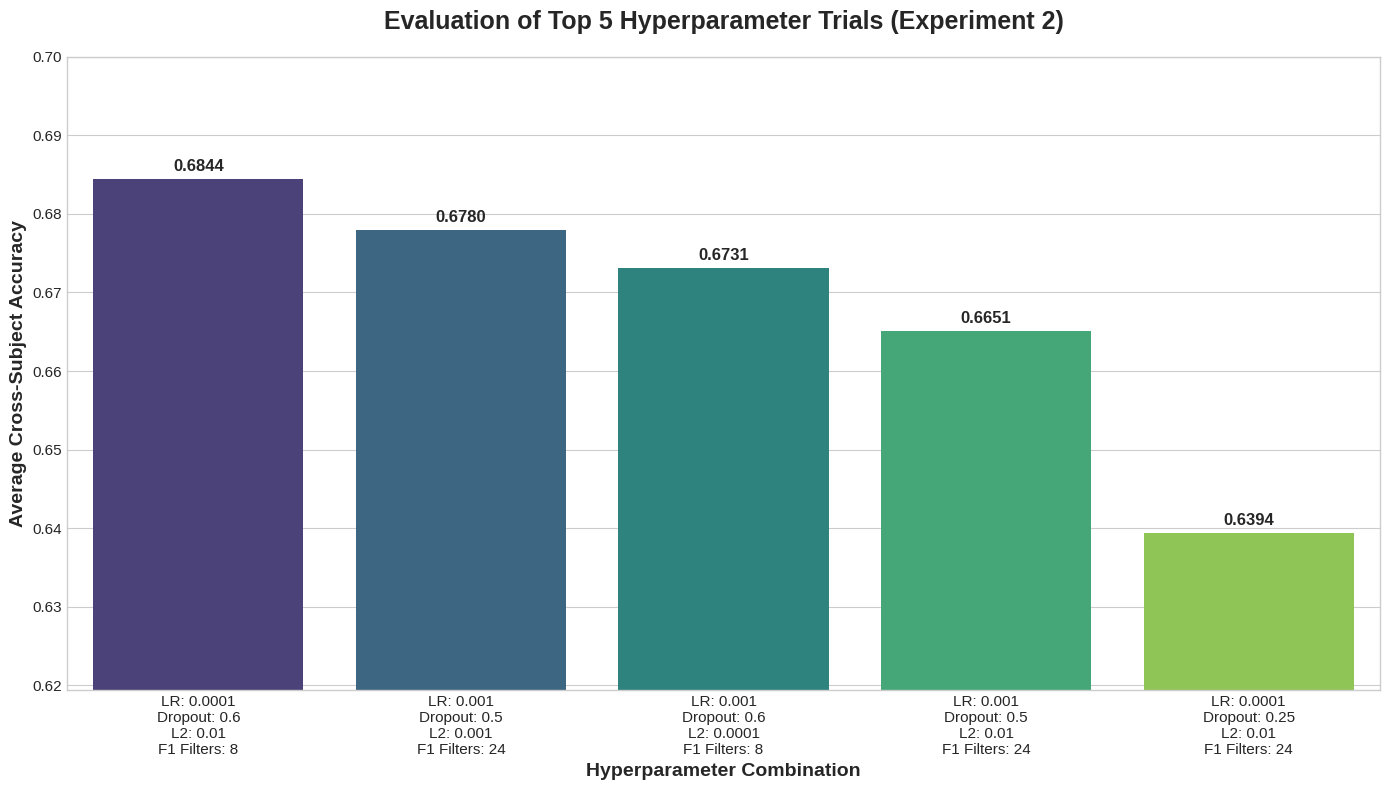

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = {
    'dropout_rate': [0.6, 0.5, 0.6, 0.5, 0.25],
    'l2_lambda': [0.01, 0.001, 0.0001, 0.01, 0.01],
    'f1_filters': [8, 24, 8, 24, 24],
    'learning_rate': [0.0001, 0.001, 0.001, 0.001, 0.0001],
    'avg_cross_subject_accuracy': [0.684436, 0.678002, 0.673100, 0.665135, 0.639400]
}
results_df = pd.DataFrame(data)
results_df = results_df.sort_values(by='avg_cross_subject_accuracy', ascending=False)
results_df['trial_label'] = [
    f"LR: {lr}\nDropout: {dr}\nL2: {l2}\nF1 Filters: {f1}"
    for lr, dr, l2, f1 in zip(
        results_df['learning_rate'],
        results_df['dropout_rate'],
        results_df['l2_lambda'],
        results_df['f1_filters']
    )
]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))


barplot = sns.barplot(
    x='trial_label',
    y='avg_cross_subject_accuracy',
    data=results_df,
    palette='viridis',
    ax=ax
)


for p in barplot.patches:
    ax.annotate(
        f'{p.get_height():.4f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=12,
        fontweight='bold'
    )

ax.set_title('Evaluation of Top 5 Hyperparameter Trials (Experiment 2)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Hyperparameter Combination', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Cross-Subject Accuracy', fontsize=14, fontweight='bold')
min_acc = results_df['avg_cross_subject_accuracy'].min()
ax.set_ylim(min_acc - 0.02, 0.7)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()